In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.transform import resize

In [2]:
seed = 42
np.random.seed = seed

In [3]:
def get_gpus():
    info = device_lib.list_local_devices()
    return [x.physical_device_desc for x in info if x.device_type == "GPU"]

In [4]:
get_gpus()

['device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5']

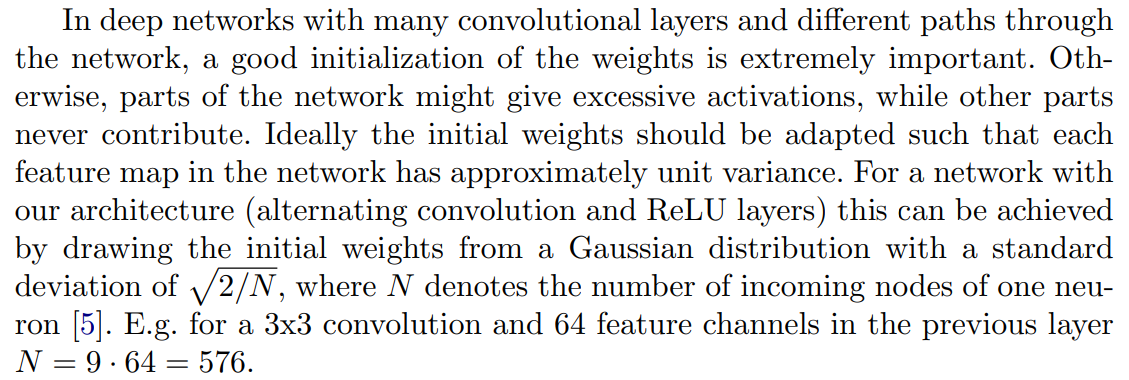

In [5]:
## Defining hyperparameters for the model training
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
TRAIN_PATH = "dataset/stage1_train/"
TEST_PATH = "dataset/stage1_test/"
os.getcwd() + TRAIN_PATH

'D:\\Deep Learning\\Image Segmentationdataset/stage1_train/'

In [6]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [7]:
X_train = np.zeros((len(os.listdir(TRAIN_PATH)), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

y_train = np.zeros((len(os.listdir(TRAIN_PATH)), IMG_HEIGHT, IMG_WIDTH, 1), dtype = bool)

X_train.shape

(670, 128, 128, 3)

In [8]:
print('Resizing training images and masks')
for n, id_ in enumerate(train_ids):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    y_train[n] = mask

Resizing training images and masks


In [9]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in enumerate(test_ids):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Resizing test images
Done!


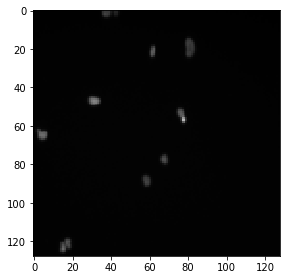

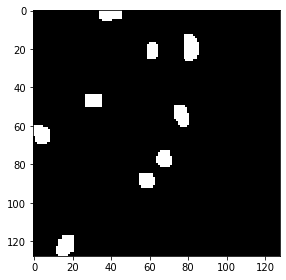

In [27]:
# Sanity Check
import random
idx = random.randint(0, len(train_ids))
imshow(X_train[idx])
plt.show()
imshow(np.squeeze(y_train[idx]))
plt.show()

In [21]:
inputs = layers.Input(shape = ((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)))
# Do I need to have floating point pixel values ????
# If I am keeping the padding = "same", then what is the need of performing two consecutive Conv2D operations at a single level
normalized = layers.Lambda(lambda x: x/255)(inputs)

########################### Down-Sampling ###############################

c1 = layers.Conv2D(16, (3, 3), padding = "same", activation = "relu", kernel_initializer="he_normal")(normalized)
c1 = layers.Conv2D(16, (3, 3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(c1)
c1 = layers.Dropout(0.2)(c1)
p1 = layers.MaxPool2D(pool_size=(2, 2))(c1)
# 64 x 64 x 16

c2 = layers.Conv2D(32, (3, 3), padding = "same", activation = "relu", kernel_initializer="he_normal")(p1)
c2 = layers.Conv2D(32, (3, 3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(c2)
c2 = layers.Dropout(0.2)(c2)
p2 = layers.MaxPool2D(pool_size=(2, 2))(c2)
# 32 x 32 x 32

c3 = layers.Conv2D(64, (3, 3), padding = "same", activation = "relu", kernel_initializer="he_normal")(p2)
c3 = layers.Conv2D(64, (3, 3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(c3)
c3 = layers.Dropout(0.2)(c3)
p3 = layers.MaxPool2D(pool_size=(2, 2))(c3)
# 16 x 16 x 64

c4 = layers.Conv2D(128, (3, 3), padding = "same", activation = "relu", kernel_initializer="he_normal")(p3)
c4 = layers.Conv2D(128, (3, 3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(c4)
c4 = layers.Dropout(0.2)(c4)
p4 = layers.MaxPool2D(pool_size=(2, 2))(c4)
# 8 x 8 x 128

c5 = layers.Conv2D(256, (3, 3), padding = "same", activation = "relu", kernel_initializer="he_normal")(p4)
c5 = layers.Conv2D(256, (3, 3), padding = "same", activation = "relu", kernel_initializer = "he_normal")(c5)
# 8 x 8 x 256

########################### Up-Sampling ###############################

u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding = "same")(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(u6)
c6 = layers.Conv2D(128, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c6)
c6 = layers.Dropout(0.1)(c6)
# 16 x 16 x 128

u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding = "same")(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(u7)
c7 = layers.Conv2D(64, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c7)
c7 = layers.Dropout(0.1)(c7)
# 32 x 32 x 64

u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding = "same")(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(32, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(u8)
c8 = layers.Conv2D(32, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c8)
c8 = layers.Dropout(0.1)(c8)
# 64 x 64 x 32

u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding = "same")(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(16, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(u9)
c9 = layers.Conv2D(16, (3, 3), padding="same", activation="relu", kernel_initializer="he_normal")(c9)
c9 = layers.Dropout(0.1)(c9)
# 128 x 128 x 16

outputs = layers.Conv2D(1, (3, 3), padding = "same", activation="sigmoid", kernel_initializer="he_normal")(c9)

In [22]:
model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

 conv2d_transpose_7 (Conv2DTran  (None, 128, 128, 16  2064       ['dropout_14[0][0]']             
 spose)                         )                                                                 
                                                                                                  
 concatenate_7 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_7[0][0]',     
                                )                                 'dropout_8[0][0]']              
                                                                                                  
 conv2d_35 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_7[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_36 (Conv2D)             (None, 128, 128, 16  2320        ['conv2d_35[0][0]']              
          

In [23]:
# results = model.fit(X, y)

In [24]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath = "saved_model/", monitor = 'val_loss', verbose = 1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TensorBoard(log_dir = "logs/", )
]

In [25]:
results = model.fit(X_train, y_train, epochs=25, batch_size = 16, verbose=1, callbacks=callbacks, validation_split=0.1)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.7518
Epoch 1: val_loss improved from inf to 0.27839, saving model to saved_model\
38/38 [==============================] - 5s 83ms/step - loss: 0.5229 - accuracy: 0.7518 - val_loss: 0.2784 - val_accuracy: 0.8575
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.2286 - accuracy: 0.9050
Epoch 2: val_loss improved from 0.27839 to 0.14074, saving model to saved_model\
38/38 [==============================] - 3s 75ms/step - loss: 0.2286 - accuracy: 0.9050 - val_loss: 0.1407 - val_accuracy: 0.9479
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.1459 - accuracy: 0.9450
Epoch 3: val_loss improved from 0.14074 to 0.11240, saving model to saved_model\
38/38 [==============================] - 3s 74ms/step - loss: 0.1459 - accuracy: 0.9450 - val_loss: 0.1124 - val_accuracy: 0.9550
Epoch 4/25
38/38 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.

3/3 [==============================] - 1s 270ms/step


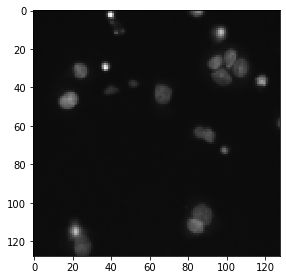

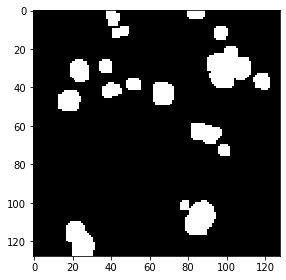

C:\ProgramData\Anaconda3\envs\deeplearning_tensorflow\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


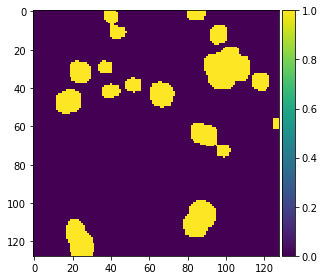

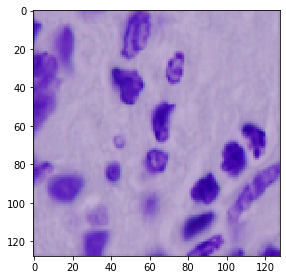

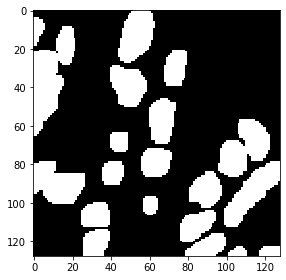

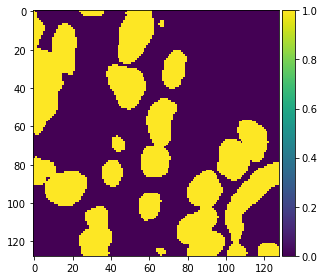

In [28]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [4]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
%tensorboard --logdir logs/